# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import glob
import math
import os
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as st
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm, trange

In [2]:
TARGET = 'product'
state = np.random.RandomState(777)

_____________
**Используемые функции**

In [3]:
# read file in DataFrame and show information about data 
def df_info(file_path: str,
            target: str = TARGET,
            **kwagrs) -> pd.DataFrame:
    print(f'File: {file_path} \n')
    data =  pd.read_csv(file_path, **kwagrs)
    data.info()
    
    print('─' * 40)
    print('Data head')
    display(data.head(3))
    
    print('─' * 40)
    print('Data describe')
    display(data.describe())
    
    print('─' * 40)
    print(f'Duplicates {"not" if data.duplicated().sum()==0 else ""} detected')
    print(f'Zero in target {(data[target] == 0).sum()}')
    
    print('─' * 40)
    ax = pd.plotting.scatter_matrix(data, alpha=0.01, figsize=(15,6))
    corr = data.corr().to_numpy()
    for i in tqdm(range(4)):
        for j in range(i+1,4):
            ax[i, j].clear()
            size_ = 10 if abs(corr[i,j]) < 0.2 else 50*abs(corr[i,j])
            ax[i, j].annotate(f"{corr[i,j]:.3f}", (0.5, 0.5), xycoords='axes fraction',
                              ha='center', va='center', size=size_)
    plt.suptitle('Correlation information')
    plt.show()
    
    
    print('─' * 40)
    _, ax = plt.subplots(nrows=2, figsize=(15,6))
    data.loc[:, data.columns != target].plot(kind='box', vert=False, ax=ax[0], grid=True, title='Features')
    data.loc[:, data.columns == target].plot(kind='box', vert=False, ax=ax[1], grid=True, title='Target')
    plt.suptitle("Boxplotes")
    return data

In [4]:
# split data to features and target 
def split_features_target(data: pd.DataFrame, target: str = TARGET) -> namedtuple:
    result = namedtuple('features', 'target')
    result.features = data.drop(columns= [target, 'id'])
    result.target = data[target]
    return result

In [5]:
def standartiz(data: pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler()
    result = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    display(result.head())
    return result

______________________

Получим имена доступных файлов по шаблону.

In [6]:
file_names = glob.glob(os.path.join("/datasets", "geo_data*.csv"))
file_names

['/datasets/geo_data_0.csv',
 '/datasets/geo_data_1.csv',
 '/datasets/geo_data_2.csv']

Доступны 3 файла -  информация по 3 различным регионам. Загрузим данные по каждому из регионов в DataFrame и оценим полученные данные.

### Регион 1

File: /datasets/geo_data_0.csv 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
────────────────────────────────────────
Data head


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


────────────────────────────────────────
Data describe


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


────────────────────────────────────────
Duplicates not detected
Zero in target 1
────────────────────────────────────────


  0%|          | 0/4 [00:00<?, ?it/s]

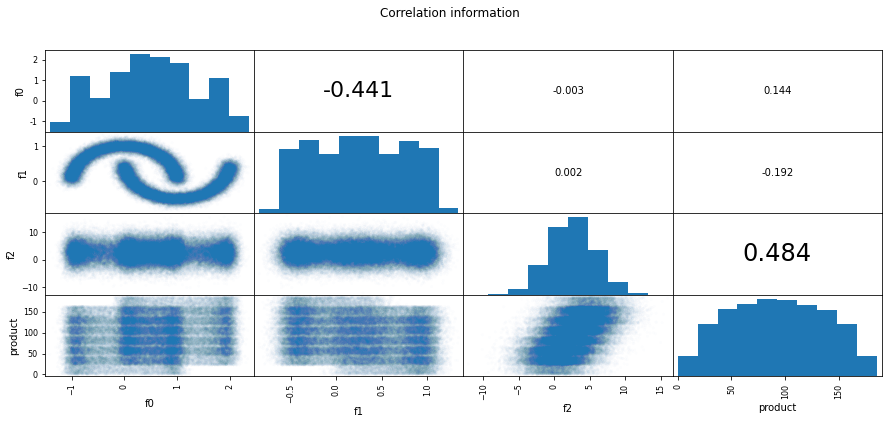

────────────────────────────────────────


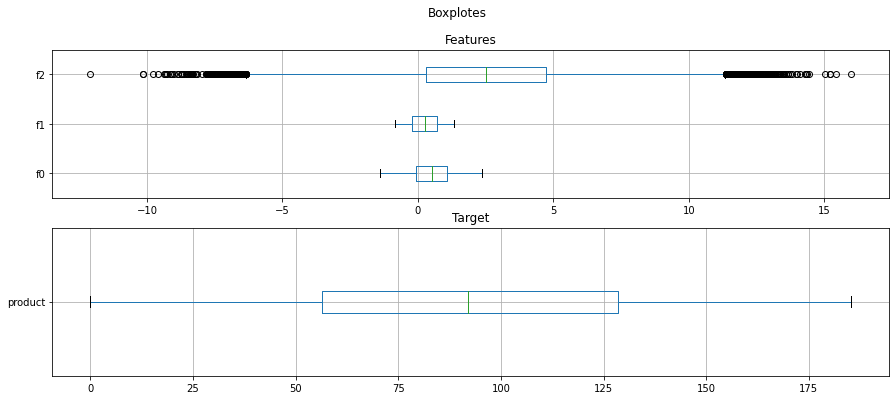

In [7]:
df_region_1 = df_info(file_names[0])

### Регион 2

File: /datasets/geo_data_1.csv 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
────────────────────────────────────────
Data head


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


────────────────────────────────────────
Data describe


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


────────────────────────────────────────
Duplicates not detected
Zero in target 8235
────────────────────────────────────────


  0%|          | 0/4 [00:00<?, ?it/s]

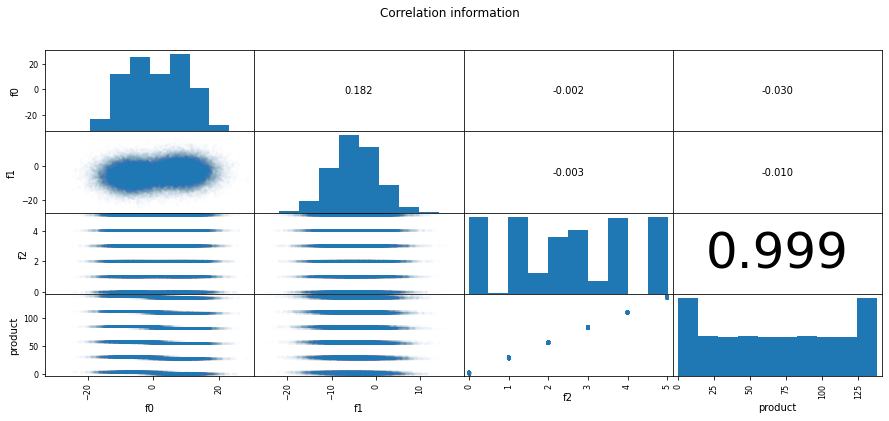

────────────────────────────────────────


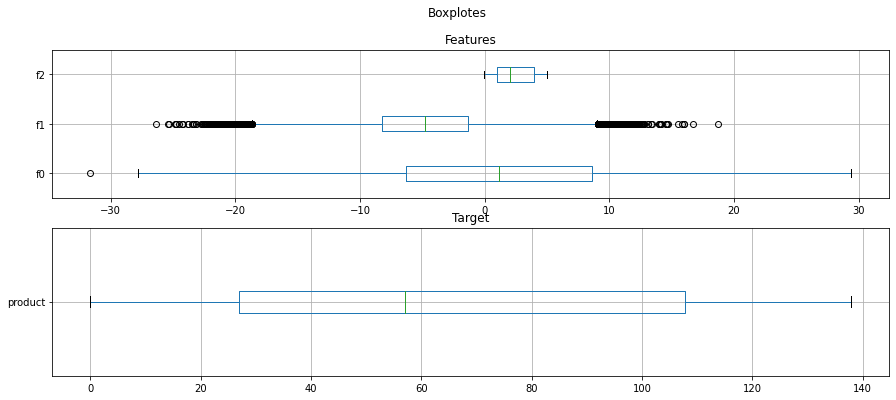

In [8]:
df_region_2 = df_info(file_names[1])

### Регион 3

File: /datasets/geo_data_2.csv 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
────────────────────────────────────────
Data head


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


────────────────────────────────────────
Data describe


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


────────────────────────────────────────
Duplicates not detected
Zero in target 1
────────────────────────────────────────


  0%|          | 0/4 [00:00<?, ?it/s]

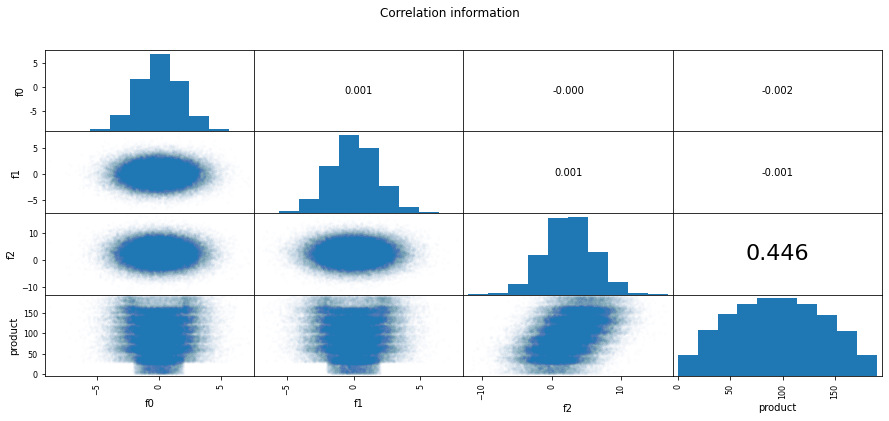

────────────────────────────────────────


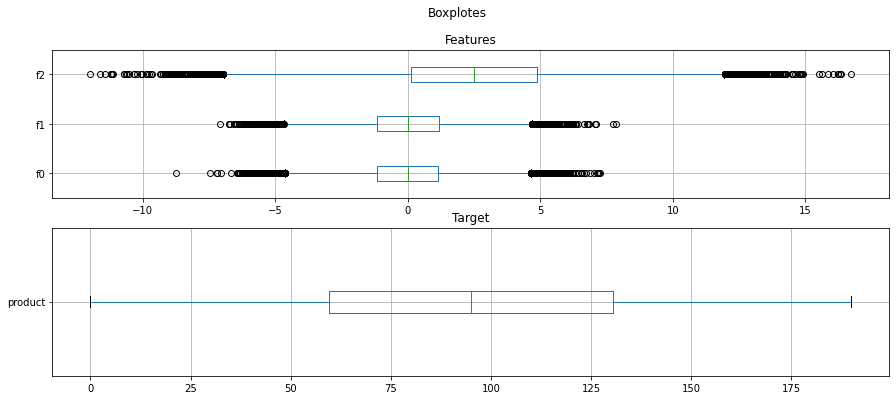

In [9]:
df_region_3 = df_info(file_names[2])

**Вывод:**

Во всех данных пропущенных значений нет, аномальных значений нет, дубликатов нет. <br>
В 1 и 3 регионе распределение целевого признака похоже на нормальное, тогда как во 2 регионе ближе к равномерному. <br>
Во 2 регионе есть **8235** нулевых целевых значений, это 8% от общего. Возможно, в этих данных содержится ошибка или же данные скважины действительно пустые. Оставим их.

______________________

### Подготовка данных

**Разделим** данные на целевой признак и признаки.

In [10]:
for i in range(1,4):
    exec(f'region_{i} = split_features_target(df_region_{i})')

Стандартизируем значения признаков.

In [11]:
for i in range(1,4):
    print(f'\nRegion {i}')
    exec(f'region_{i}.features = standartiz(region_{i}.features)')


Region 1


,f0,f1,f2
0,0.235512,-1.482793,-0.394515
1,0.956946,-1.170246,0.573368
2,0.599101,-0.194581,-0.333326
3,-0.610890,-0.220269,0.146516
4,1.706773,-0.187797,0.692414



Region 2


,f0,f1,f2
0,-1.800451,-0.679595,-1.467757
1,1.464528,0.258112,-0.877783
2,0.571264,-0.224969,1.471398
3,-1.586290,-1.310484,1.470373
4,1.289432,-0.654483,1.473278



Region 3


,f0,f1,f2
0,-0.663387,0.557908,-0.957007
1,0.150548,0.157142,-1.446788
2,0.111178,0.168235,-2.326682
3,1.289833,-0.318815,-0.450590
4,-0.299079,0.993029,0.979978


**Вывод:**

- загружены данные из файлов
- проведена проверка на пропуски, дубликаты и аномальные значения
- данные разбиты на целевой признак и признаки
- произведена стандартизация признаков

## Обучение и проверка модели

_____________
**Используемые функции**

In [12]:
def split_train_validate(data: pd.DataFrame, 
                         test_size: float = 0.25) -> namedtuple:
    train = namedtuple('features', 'target')
    valid = namedtuple('features', 'target')
    train.features, valid.features, train.target, valid.target = train_test_split(data.features, 
                                                                                  data.target, 
                                                                                  test_size=0.25,
                                                                                  random_state=state)
    print(f"Training sample size {len(train.features)}, percentage of total {len(train.features)/len(data.features):.0%}")
    print(f"Validation sample size {len(valid.features)}, percentage of total {len(valid.features)/len(data.features):.0%}")
    return train, valid

In [13]:
def create_model(data: pd.DataFrame, 
                 test_size: float = 0.25) -> namedtuple:
    #split data
    train, valid = split_train_validate(data, test_size)
    
    print('─' * 40)
    result = namedtuple('pred','real')
    #create model 
    model = LinearRegression()
    model.fit(train.features, train.target)
    print(f'Model coeffitients: {model.coef_}')
    #predict
    result.pred = pd.Series(model.predict(valid.features))
    #metrics
    rmse = mean_squared_error(valid.target, result.pred)**0.5
    print(f'Model RMSE =  {rmse:.3f}')
    print(f'Model normalized RMSE =  {rmse / (max(result.pred) - min(result.pred)):.3f}')
    #mean of predict
    print(f'Average reserve = {result.pred.mean():.3f}')
    
    print('\n\nGraphs of real and predicted values')
    res = pd.concat([result.pred, valid.target.reset_index(drop=True)], axis=1)
    res.columns = ['predict', 'real']
    sns.boxplot(data=res, orient="h", showmeans=True)
    plt.show()
    res = res.sample(n=200, random_state=state).sort_values(by='predict').reset_index(drop=True)
    res['predict'].plot.line(figsize=(15,5))
    res['real'].plot(style='.')
    plt.legend(['pridict','real'])
    plt.xticks([])
    result.real = valid.target
    result.pred.index = result.real.index 
    return result

_______________

Для каждого региона: 
- разобьем данные на тестовую и валидационные выборки
- построим модель линейной регрессии 
- выведем RMSE для валидационной выборки
- выведем средний запас топлива
- сохраним предсказанные значения

### Регион 1

Training sample size 75000, percentage of total 75%
Validation sample size 25000, percentage of total 25%
────────────────────────────────────────
Model coeffitients: [ 3.32116379 -7.07942373 21.43679354]
Model RMSE =  37.992
Model normalized RMSE =  0.210
Average reserve = 92.717


Graphs of real and predicted values


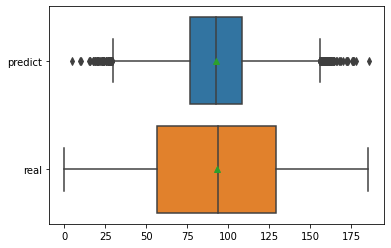

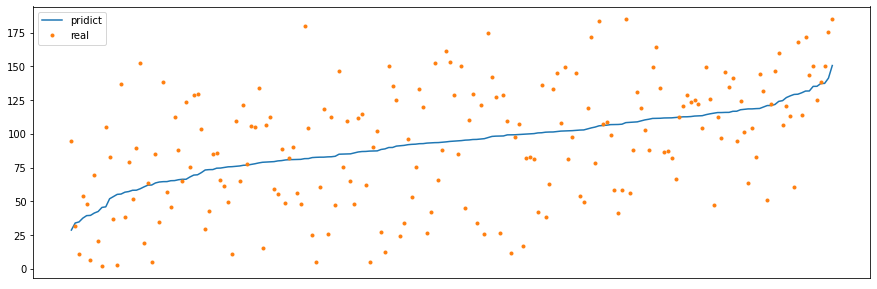

In [14]:
result_region_1 = create_model(region_1)

### Регион 2

Training sample size 75000, percentage of total 75%
Validation sample size 25000, percentage of total 25%
────────────────────────────────────────
Model coeffitients: [-1.29764706 -0.11123277 45.91539614]
Model RMSE =  0.887
Model normalized RMSE =  0.006
Average reserve = 68.945


Graphs of real and predicted values


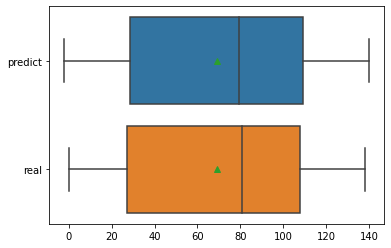

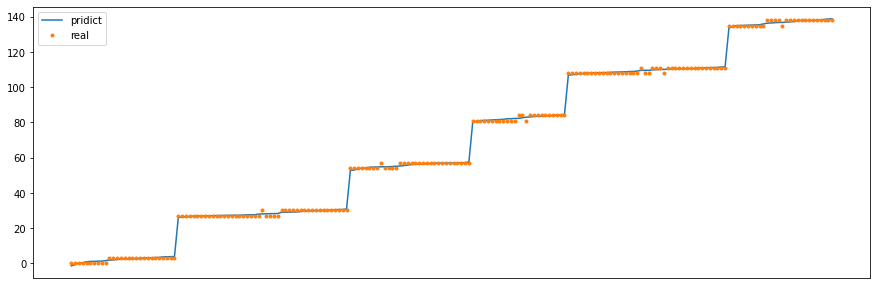

In [15]:
result_region_2 = create_model(region_2)

### Регион 3

Training sample size 75000, percentage of total 75%
Validation sample size 25000, percentage of total 25%
────────────────────────────────────────
Model coeffitients: [-0.07826637 -0.14395221 20.02736027]
Model RMSE =  39.954
Model normalized RMSE =  0.253
Average reserve = 94.853


Graphs of real and predicted values


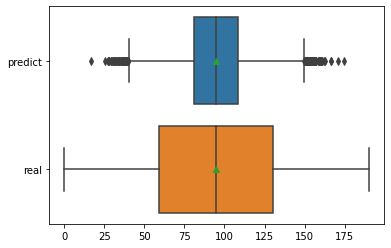

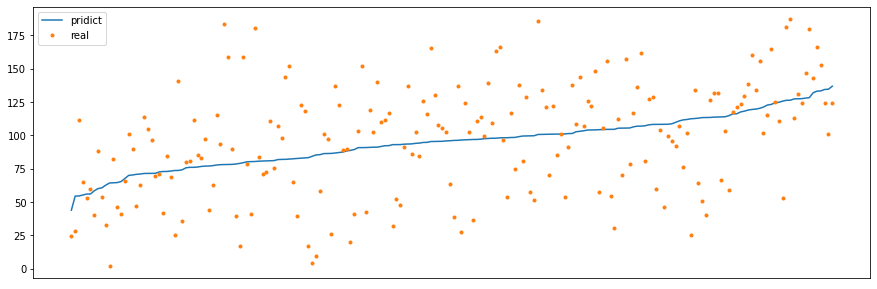

In [16]:
result_region_3 = create_model(region_3)

### Вывод

Средние запасы топлива в скважине практически равны во 1 и 3 регионах (**92.7** и **94.8** соответственно), во 2 регионе средние запасы значительно меньше (**69**) <br>
При этом RMSE модели для второго региона минимальный - **0.9** (нормализованный RMSE близок к нулю - **0.006**), что говорит о хорошей предсказательной способности модели. <br>
Тогда как RMSE для первого и третьего региона **37.9** и **40**, что при диапазоне целевого признака от 0 до ~200 не так мало(нормализованные RMSE ~**0.2**) => у моделей не очень хорошая предсказательная способность.

## Подготовка к расчёту прибыли


- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
-    Бюджет на разработку скважин в регионе — 10 млрд рублей.
-    При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

Будем считать в тыс. рублей.

In [17]:
MAX_WELLS = 500
CHOOSE_WELLS = 200
REGION_BUDGET = 10 ** 7
PROFIT_PER_UNIT = 450

In [18]:
min_barrel = math.ceil(REGION_BUDGET / PROFIT_PER_UNIT)
mean_well_barrel = min_barrel / CHOOSE_WELLS
print(f'Min barrel per region: {min_barrel:_}'.replace('_',' '))
print(f'Average barrel per well: {mean_well_barrel}')

Min barrel per region: 22 223
Average barrel per well: 111.115


**Вывод:**

При разработке 200 скважин в регионе средний запас сырья должен быть **111** единиц. На всем объеме данных ни один из регионов не обладает подобным средним запасом. Но т.к. разрабатывать планируется не все точки региона, а только 200 лучших, то и данные про среднее могут значительно измениться. <br>
Минимальное количество баррелей в регионе должно быть не менее **22 223** единиц для безубыточной разработки.

## Расчёт прибыли и рисков 

**Используемые функции**

In [19]:
def find_profit(data: pd.Series) -> float:
    return (data.sum() * PROFIT_PER_UNIT - REGION_BUDGET)

In [20]:
def bootstrapping(data: namedtuple, n_samples: int = 1_000) -> None:
    profit = []
    mean_barrel = []
    for i in trange(n_samples):
        #supsample 500 spot and choose 200 better
        subsample = data.pred.sample(n=MAX_WELLS, replace=True, random_state=state)
        sub_better = subsample.sort_values().tail(CHOOSE_WELLS) 
        
        #change to real
        sub_better = data.real.loc[sub_better.index]
          
        #mean barrel and profit
        mean_barrel.append(sub_better.mean())
        profit.append(find_profit(sub_better))
    
    mean_barrel = pd.Series(mean_barrel)
    profit = pd.Series(profit)
    
    print(f'Average barrel per well in region: {mean_barrel.mean():.3f}')

    print('─' * 40)
    profit.hist()
    plt.xlabel("Profit")
    plt.ylabel("Count")
    plt.title('Profit Histogram')
    plt.show()
    #confidence interval profit
    lower = profit.quantile(0.025)
    upper =  profit.quantile(0.975) 
    print(f'Confidence interval profit: {lower:,.2f} — {upper:,.2f} thousand rubles')
    print(f'Mean profit {profit.mean():,.2f} thousand rubles')
    
    print('─' * 40)
    #find with negative profit
    print(f'Count of sample with negative profit: {(profit < 0).sum()}')
    print(f'Negative profit chance: {(profit < 0).mean():.2%}')

_____________________

С помощью Bootstrap на 1000 повторений для каждого региона выберем по 500 скважин, из которых отберем 200 лучших. <br>
Для отобранных скважин посчитаем прибыль и вероятность убытков.

### Регион 1

  0%|          | 0/1000 [00:00<?, ?it/s]

Average barrel per well in region: 116.089
────────────────────────────────────────


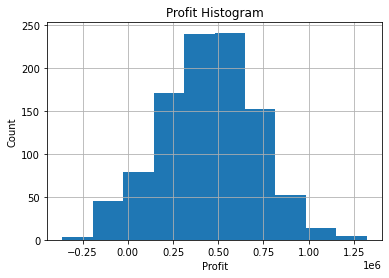

Confidence interval profit: -95,155.65 — 954,120.67 thousand rubles
Mean profit 448,053.15 thousand rubles
────────────────────────────────────────
Count of sample with negative profit: 53
Negative profit chance: 5.30%


In [21]:
bootstrapping(result_region_1)

### Регион 2

  0%|          | 0/1000 [00:00<?, ?it/s]

Average barrel per well in region: 116.349
────────────────────────────────────────


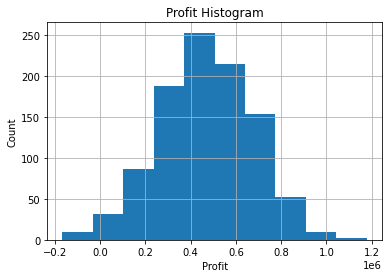

Confidence interval profit: 46,748.74 — 859,440.88 thousand rubles
Mean profit 471,452.07 thousand rubles
────────────────────────────────────────
Count of sample with negative profit: 14
Negative profit chance: 1.40%


In [22]:
bootstrapping(result_region_2)

### Регион 3

  0%|          | 0/1000 [00:00<?, ?it/s]

Average barrel per well in region: 114.887
────────────────────────────────────────


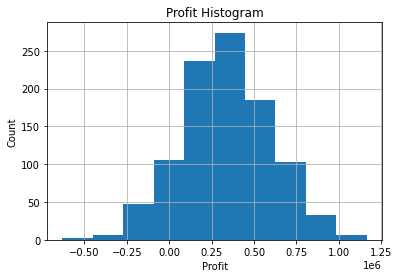

Confidence interval profit: -179,592.00 — 870,507.23 thousand rubles
Mean profit 339,830.07 thousand rubles
────────────────────────────────────────
Count of sample with negative profit: 95
Negative profit chance: 9.50%


In [23]:
bootstrapping(result_region_3)

**Вывод**

- для каждого региона средний запас ресурса в точке не меньше необходимого для безубыточности, равном **111**
- вероятность убытков в 1 и 3 регионах **5.3%** и **9.5%** соответственно, что больше необходимых **2.5%**
- во втором регионе вероятность убытков **1.4%** 
- максимальный средний профит у второго региона **471,452.07** тыс.рублей

## Общий вывод

**Было сделано:**
- получены и обработаны данные
- построена линейная модель для каждого из регионов и сделаны предсказания
- подсчитаны необходимые экономические величины
- расчитана прибыль и вероятность убытков для каждого из регионов

**Сводка**

***1 Регион:***
- средний запас ресурса в скважине **116.089**
- средняя прибыль **448,053.15** тыс.рублей
- вероятность убытков **5.3%**


***2 Регион:***
- средний запас ресурса в скважине **116.349**
- средняя прибыль **471,452.07** тыс.рублей
- вероятность убытков **1.4%**


***3 Регион:***
- средний запас ресурса в скважине **114.887**
- средняя прибыль **339,830.07** тыс.рублей
- вероятность убытков **9.5%**

**Рекомендации:**

Для разработки можно рекомендовать **второй регион**:
- для него самое высокое качество модели и предсказательная способность. 
- только этот регион имеет вероятность убытков менее **2.5%**
- средняя прибыль по нему максимальна.